In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_circles
from sklearn.neighbors import kneighbors_graph
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

Importing Data 


In [ ]:
X = np.load('/content/gdrive/MyDrive/ML Datasets/test_1.npy')
Y = np.load('/content/gdrive/MyDrive/ML Datasets/test_1_y.npy')

Traditional Spectral Clustering

Making the Laplacian Matrix

In [ ]:
#Similarity Matrix based on Cosine Similarity
A = cosine_similarity(X)
#Similarity based on Euclidean 

In [ ]:
#Laplacian Matrix
D =np.diag(A.sum(axis=1))
L = D - A

Eigen Values of L

In [ ]:
vals, vecs = np.linalg.eig(L)

In [ ]:
#Findings Number of Clusters(Not working)
index_largest_gap = np.argsort(np.diff(vals))[::-1][:5]
nb_clusters = index_largest_gap + 1

In [ ]:
index_largest_gap + 1

array([   2,    4, 1874, 1871,   18])

In [ ]:
# sort according to Eigen values
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]

In [ ]:
#Runing A k means on vector corressponding to second smallest eigenValue
vecs_cluster =  vecs[:,1:2]*1e5
clusters = (KMeans(n_clusters=nb_clusters,init = 'random', max_iter =200).fit((vecs_cluster)))
clusters = clusters.labels_

In [ ]:
#Visualizing the Input data
pca = PCA(n_components=len(X[0]), whiten = False, random_state = 2019)
X_pca = pca.fit_transform(X)

In [ ]:
np.save('/content/gdrive/MyDrive/ML Datasets/test1_pca.npy', np.array(X_pca[:,:32]))

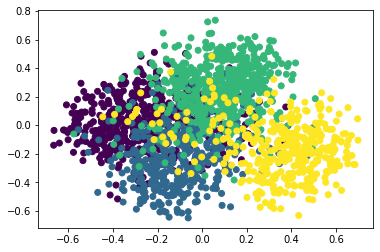

In [ ]:
#Get the scatter plot for Input Data
plt.scatter(X_pca[:,0],X_pca[:,1],c = Y)

0.2793306561886832

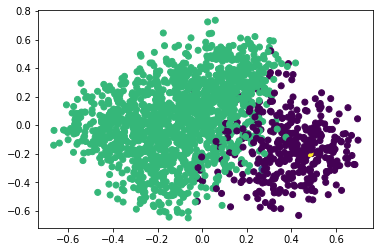

In [ ]:
#Get the scatter plot for our Spectral Output and NMI Score
plt.scatter(X_pca[:,0],X_pca[:,1],c = clusters)
normalized_mutual_info_score(clusters,Y)

0.5144222461176954

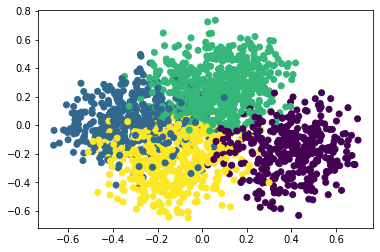

In [ ]:
#Get the scatter plot for Library Spectral Clustering and NMI Score
clusters_sc = SpectralClustering(n_clusters=nb_clusters).fit(X).labels_
plt.scatter(X_pca[:,0],X_pca[:,1],c = clusters_sc)
normalized_mutual_info_score(clusters_sc,Y)


Finding optimal Clusters using Elbow method


In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(2, 20)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k,init = 'random').fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

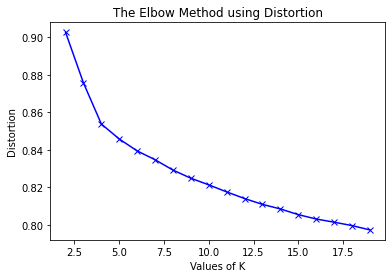

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

K Means using Cosine Distance

In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import silhouette_score
import random

def calc_distance(A, B):  
    return 1-(np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))
def findClosestCentroids(ic, X):
    assigned_centroid = []
    for i in X:
        distance=[]
        for j in ic:
            distance.append(calc_distance(i, j))
        assigned_centroid.append(np.argmin(distance))
    return assigned_centroid
def calc_centroids(clusters, X):
    new_centroids = []
    new_df = pd.concat([pd.DataFrame(X), pd.DataFrame(clusters, columns=['cluster'])],
                      axis=1)
    for c in set(new_df['cluster']):
        current_cluster = new_df[new_df['cluster'] == c][new_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        new_centroids.append(cluster_mean)
    return new_centroids
def kmeans(df1,k):
  init_centroids = random.sample(range(0, len(df1)), k)
  centroids = []
  for i in init_centroids:
    centroids.append(df1[i])
  centroids = np.array(centroids)
  get_centroids = findClosestCentroids(centroids, df1)
  for i in range(8):
    get_centroids = findClosestCentroids(centroids, df1)
    centroids = calc_centroids(get_centroids,df1)
    #print(centroids)
   
  return np.array(get_centroids)
def KmeansMain(results,noOfClusters=-1):
    res = np.array(results)
    sil = []
    kmax = 90
    
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    if(noOfClusters >0):
      optimal_k = noOfClusters
    else:
      for k in range(2, kmax+1):
        labels = kmeans(res,k)
        sil.append(silhouette_score(res, labels, metric = 'cosine'))
      optimal_k = sil.index(max(sil)) +2
   
    final_labels = kmeans(res,optimal_k)
#arranging labels in order  
    curr_label = 0
    visited1 = set()
    dict1 = {}
    for i in final_labels:
      if(i not in visited1):
        dict1[i] = curr_label
        curr_label+=1
        visited1.add(i)
    final_labels_ordered = np.array([dict1[labl] for labl in final_labels])

      

    return final_labels_ordered

Spectral Clustering Implementation From google's Paper
(Some Parts of the code have been taken from https://github.com/wq2012/SpectralCluster/blob/master/spectralcluster)


In [ ]:
from scipy.ndimage import gaussian_filter


In [ ]:
#Parameters Used
sigma = 1
p_percentile = 0.95
soft_multiplier=0.009

In [ ]:
#Similarity Matrix based on Cosine Similarity
A = cosine_similarity(X)

In [ ]:
#Gaussain Blurr
A = gaussian_filter(A, sigma=sigma)
# Row Wise Thresholding
row_percen = np.percentile(A, p_percentile * 100, axis=1)
A1 = []
for i in range(0,len(A)):
  A1.append(A[i]<row_percen[i])
A1 = np.array(A1) 
A  = A*(1-A1) + A*soft_multiplier*A1

#Symmetrization
A = np.maximum(A, np.transpose(A))
#Diffusion
A = np.matmul(A, np.transpose(A))
#Normalization
row_max = A.max(axis=1)
A /= np.expand_dims(row_max, axis=1)

In [ ]:
#Finding Eigen vectors and Eigen gap method to find the optimal Number of clusters
vals,vecs = np.linalg.eig(A)
vals = vals.real
vecs = vecs.real
vecs = vecs[:,np.argsort(-1*vals)]
vals = vals[np.argsort(-1*vals)]
max_delta = 0
max_delta_index = 0
for i in range(2, len(vals)):
        if vals[i - 1] < 1e-2:
            break
        delta = vals[i - 1] / vals[i]
        if delta > max_delta:
            max_delta = delta
            max_delta_index = i
n_clusters_sc = max_delta_index


In [ ]:
n_clusters_sc


4

In [ ]:
vecs_cluster = vecs[:, :n_clusters_sc]
clusters_sc_g = (KMeans(n_clusters=n_clusters_sc,init = 'k-means++', max_iter =2000).fit((vecs_cluster))).labels_
# clusters_sc_g = KmeansMain(vecs_cluster)

In [ ]:
plt.scatter(X_pca[:,0],X_pca[:,1],c = clusters_sc_g)
normalized_mutual_info_score(clusters_sc_g,Y)